# DataFrames

Os **DataFrames** son unha parte fundamental da **API estruturada de Spark** (*Spark Structured API*). Esta API permite manipular datos **non estruturados**, **semi-estruturados** (por exemplo, CSV ou JSON) e **altamente estruturados** (por exemplo, Parquet ou táboas).

Dentro da API estruturada considéranse tres tipos principais de coleccións distribuídas:

- **Datasets**: son a versión con **tipado máis forte** dos DataFrames. Permiten comprobación de tipos en tempo de compilación e ofrecen maior seguridade. Só están dispoñibles en linguaxes baseadas na JVM, como **Scala** e **Java**.

- **DataFrames**: coleccións distribuídas con forma de **táboa**, con filas e columnas ben definidas, onde cada fila é un rexistro e cada columna ten un nome e un tipo. A diferenza dos Datasets, o tipado é **menos estrito** e a validación complétase principalmente en **tempo de execución**.

- **Táboas e vistas SQL**: pódense crear **táboas** ou **vistas temporais** a partir de DataFrames, permitindo executar consultas SQL sobre elas. A función `spark.sql()` permite lanzar consultas SQL directamente cando estas táboas/vistas están rexistradas no catálogo.

---

## Proceso de execución na API estruturada

O proceso que se segue para executar un traballo usando DataFrames, Datasets ou SQL é o seguinte:

1. Escríbese o código para manipular **DataFrames / Datasets / SQL**.
2. Se o código é válido, Spark constrúe un **Plan Lóxico** (*Logical Plan*).
3. Spark transforma o Plan Lóxico nun **Plan Físico** (*Physical Plan*), aplicando optimizacións durante o proceso.
4. Spark executa o Plan Físico no clúster, converténdoo en tarefas distribuídas que se procesan en paralelo.

---

## O Plan Lóxico

O **Plan Lóxico** representa unha serie de transformacións abstractas, sen facer referencia a *executores*, *drivers* ou recursos físicos do clúster.  

A partir do código do usuario xérase inicialmente un **plan lóxico sen resolver** (*Unresolved Logical Plan*). Este plan contén referencias a columnas, táboas ou funcións, pero aínda non se validou se existen ou se son correctas.

Despois, Spark analiza ese plan co apoio do **Catálogo** (*Catalog*), un repositorio que contén metadatos sobre:
- táboas
- vistas
- columnas e tipos
- funcións rexistradas
- bases de datos

Este proceso dá lugar a un **plan lóxico resolto** (*Resolved Logical Plan*), no que xa se comprobaron nomes e tipos. A continuación, Spark aplica optimizacións (por exemplo eliminación de columnas non usadas, reordenación de filtros, simplificación de expresións...) para obter o **Plan Lóxico Optimizado** (*Optimized Logical Plan*).

![Plan lóxico](./images/logicalplan.png)

---

## O Plan Físico

O **Plan Físico** (tamén chamado *Spark Plan*) describe como se executará realmente o Plan Lóxico no clúster. Neste punto Spark decide:

- que estratexia de execución se vai empregar (por exemplo, tipo de join)
- como se van repartir os datos entre particións
- cando se vai producir un shuffle
- que operadores físicos se van usar

Para isto, Spark adoita xerar **varias estratexias alternativas** e escoller a mellor empregando un **modelo de custo** (baseado en estimacións do tamaño de datos, estatísticas e custo de operacións).

![Plan físico](./images/physicalplan.png)

---

## Resultado final

O resultado final do proceso é un conxunto de operacións físicas que Spark executa de forma distribuída no clúster. Internamente, estas operacións tradúcense en **tarefa distribuídas** que traballan sobre estruturas de baixo nivel (historicamente baseadas en *RDDs*, aínda que en execución moderna tamén se apoian en operadores optimizados e en xestión interna de memoria).

En definitiva, Spark transforma consultas realizadas sobre **DataFrames / Datasets / SQL** nun conxunto de operacións distribuídas executadas en paralelo no clúster, aplicando optimizacións para mellorar o rendemento.


In [1]:

# Inicializamos SparkSession e SparkContext
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("03-Dataframes") \
    .config("spark.sql.legacy.timeParserPolicy", "LEGACY") \
    .getOrCreate()

print(spark.version)  # Verifica a versión de Spark

#spark = SparkSession.builder.getOrCreate()

sc = spark.sparkContext

:: loading settings :: url = jar:file:/opt/spark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/hadoop/.ivy2/cache
The jars for the packages stored in: /home/hadoop/.ivy2/jars
io.delta#delta-spark_2.12 added as a dependency
org.apache.spark#spark-sql-kafka-0-10_2.12 added as a dependency
org.apache.kafka#kafka-clients added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-46a39b19-2835-4903-b42a-3bfdcad488fb;1.0
	confs: [default]
	found io.delta#delta-spark_2.12;3.1.0 in central
	found io.delta#delta-storage;3.1.0 in central
	found org.antlr#antlr4-runtime;4.9.3 in central
	found org.apache.spark#spark-sql-kafka-0-10_2.12;3.5.7 in central
	found org.apache.spark#spark-token-provider-kafka-0-10_2.12;3.5.7 in central
	found org.apache.hadoop#hadoop-client-runtime;3.3.4 in central
	found org.apache.hadoop#hadoop-client-api;3.3.4 in central
	found org.xerial.snappy#snappy-java;1.1.10.5 in central
	found org.slf4j#slf4j-api;2.0.7 in central
	found commons-logging#commons-logging;1.1.3 in central
	found com.google.code.fi

3.5.7


## Creación de DataFrames

Pódense crear **DataFrames** a partir de diversas fontes. Un dos métodos máis habituais consiste en construílos a partir dun **RDD**, convertendo os seus elementos en filas e asignándolles un esquema (explícito ou inferido).

### A partir dun RDD: `toDF()`

O método `toDF()` permite converter un RDD nun DataFrame. Para poder utilizalo en PySpark, é necesario importar previamente as funcións implicadas e, en moitos casos, indicar os nomes das columnas.

O proceso pode facerse de dúas maneiras principais:

- Convertendo un RDD de tuplas e indicando o nome das columnas.
- Convertendo un RDD de obxectos/fichas e definindo un esquema de forma explícita (con `StructType`).




In [4]:
# Exemplo: Crear un DataFrame con números consecutivos usando spark.range()

# Xeramos un DataFrame con valores do 0 ao 49 e convertímolo para asignarlle un nome á columna
df = spark.range(50).toDF("number")

# Amosamos o contido do DataFrame xerado
df.show()


[Stage 0:>                                                          (0 + 1) / 1]

+------+
|number|
+------+
|     0|
|     1|
|     2|
|     3|
|     4|
|     5|
|     6|
|     7|
|     8|
|     9|
|    10|
|    11|
|    12|
|    13|
|    14|
|    15|
|    16|
|    17|
|    18|
|    19|
+------+
only showing top 20 rows



In [5]:
# Exemplo: Crear un DataFrame a partir dun RDD de tuplas usando toDF()

# Creamos un RDD de tuplas (cada tupla será unha fila)
rdd = sc.parallelize([
    (1, "Ana", 22),
    (2, "Brais", 25),
    (3, "Carla", 21)
])

# Convertimos o RDD nun DataFrame indicando os nomes das columnas
df = rdd.toDF(["id", "nome", "idade"])

# Amosamos o DataFrame resultante
print("DataFrame creado a partir dun RDD de tuplas:")
df.show()

DataFrame creado a partir dun RDD de tuplas:


[Stage 3:>                                                          (0 + 1) / 1]

+---+-----+-----+
| id| nome|idade|
+---+-----+-----+
|  1|  Ana|   22|
|  2|Brais|   25|
|  3|Carla|   21|
+---+-----+-----+



### A partir dun arquivo (lectura con `spark.read`)

Un dos métodos máis habituais para crear DataFrames é cargalos desde ficheiros almacenados no sistema de ficheiros local, HDFS, S3, etc. Para iso utilízase o obxecto `spark.read`, que ofrece métodos específicos para distintos formatos.

O patrón xeral é sempre o mesmo:

1. Selecciónase o formato (`json`, `csv`, `parquet`, etc.)
2. Indícase a ruta ao ficheiro ou directorio
3. Opcionalmente configúranse opcións (por exemplo, `header`, `inferSchema`, `sep`, etc.)
4. Obtense un DataFrame que xa pode ser consultado con `show()`, `printSchema()`, `select()`, etc.

En moitos formatos (por exemplo CSV ou JSON) Spark pode inferir o esquema automaticamente, aínda que tamén se pode definir un esquema explícito para mellorar rendemento e evitar erros.

- json

In [7]:
# Exemplo: Crear un DataFrame a partir dun ficheiro JSON almacenado en HDFS

# Cargamos un ficheiro JSON desde HDFS e creamos automaticamente un DataFrame
df2 = spark.read.json("hdfs:///data/flight-data/json/2010-summary.json")

# Amosamos as primeiras filas do DataFrame para verificar que os datos se cargaron correctamente
df2.show()

# Amosamos o esquema inferido por Spark (nomes de columnas e tipos de datos)
df2.printSchema()


+--------------------+-------------------+-----+
|   DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|
+--------------------+-------------------+-----+
|       United States|            Romania|    1|
|       United States|            Ireland|  264|
|       United States|              India|   69|
|               Egypt|      United States|   24|
|   Equatorial Guinea|      United States|    1|
|       United States|          Singapore|   25|
|       United States|            Grenada|   54|
|          Costa Rica|      United States|  477|
|             Senegal|      United States|   29|
|       United States|   Marshall Islands|   44|
|              Guyana|      United States|   17|
|       United States|       Sint Maarten|   53|
|               Malta|      United States|    1|
|             Bolivia|      United States|   46|
|            Anguilla|      United States|   21|
|Turks and Caicos ...|      United States|  136|
|       United States|        Afghanistan|    2|
|Saint Vincent and..

- csv:

In [8]:
# Exemplo: Crear un DataFrame a partir dun ficheiro CSV en HDFS e controlar o número de particións

# Cargamos un ficheiro CSV desde HDFS indicando que a primeira liña contén os nomes das columnas (header)
# Despois reducimos o número de particións a 5 usando coalesce para evitar un shuffle innecesario
df_csv = spark.read.option("header", True).csv("hdfs:///data/flight-data/csv/2015-summary.csv").coalesce(5)

# Amosamos as 10 primeiras filas do DataFrame para comprobar a lectura e o contido
df_csv.show(10)

# Amosamos o esquema do DataFrame (os tipos poden quedar como string se non se infire o esquema)
df_csv.printSchema()

# Consultamos cantas particións ten o DataFrame converténdoo a RDD
num_particions = df_csv.rdd.getNumPartitions()

# Amosamos o resultado final: número de particións nas que está dividido o DataFrame
print("Número de particións do DataFrame: ", num_particions)


+-----------------+-------------------+-----+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|
+-----------------+-------------------+-----+
|    United States|            Romania|   15|
|    United States|            Croatia|    1|
|    United States|            Ireland|  344|
|            Egypt|      United States|   15|
|    United States|              India|   62|
|    United States|          Singapore|    1|
|    United States|            Grenada|   62|
|       Costa Rica|      United States|  588|
|          Senegal|      United States|   40|
|          Moldova|      United States|    1|
+-----------------+-------------------+-----+
only showing top 10 rows

root
 |-- DEST_COUNTRY_NAME: string (nullable = true)
 |-- ORIGIN_COUNTRY_NAME: string (nullable = true)
 |-- count: string (nullable = true)

Número de particións do DataFrame:  1


- parquet

In [9]:
# Exemplo: Crear un DataFrame a partir dun ficheiro Parquet almacenado en HDFS

# Cargamos un ficheiro Parquet desde HDFS e creamos o DataFrame
# Parquet é un formato columnar e inclúe o esquema, polo que Spark non precisa inferilo
df_parquet = spark.read.parquet("hdfs:///data/flight-data/parquet/2010-summary.parquet")

# Amosamos as 10 primeiras filas do DataFrame para comprobar a lectura e o contido
df_parquet.show(10)

# Amosamos o esquema do DataFrame (en Parquet xa vén definido dentro do propio ficheiro)
df_parquet.printSchema()


[Stage 9:>                                                          (0 + 1) / 1]

+-----------------+-------------------+-----+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|
+-----------------+-------------------+-----+
|    United States|            Romania|    1|
|    United States|            Ireland|  264|
|    United States|              India|   69|
|            Egypt|      United States|   24|
|Equatorial Guinea|      United States|    1|
|    United States|          Singapore|   25|
|    United States|            Grenada|   54|
|       Costa Rica|      United States|  477|
|          Senegal|      United States|   29|
|    United States|   Marshall Islands|   44|
+-----------------+-------------------+-----+
only showing top 10 rows

root
 |-- DEST_COUNTRY_NAME: string (nullable = true)
 |-- ORIGIN_COUNTRY_NAME: string (nullable = true)
 |-- count: long (nullable = true)



### Esquemas en DataFrames

Aínda que os **DataFrames** non sexan tan fortemente tipados como os **Datasets**, Spark permite asignar un **tipo de dato** a cada columna (campo) mediante un **esquema** (*schema*). A diferenza dos Datasets, a comprobación de tipos realízase principalmente en **tempo de execución**, pero contar cun esquema explícito mellora a calidade e fiabilidade do procesamento.

Para coñecer o esquema dun DataFrame pódese usar o método `printSchema()`.

Con respecto ao esquema, existen dúas opcións principais:
- deixar que Spark o **infira automaticamente** (por exemplo, usando `inferSchema=True` en CSV)
- **especificar explicitamente o esquema**, definindo o nome, tipo e nulabilidade de cada campo

Definir o esquema de forma explícita adoita ser recomendable porque:
- evita erros de inferencia (por exemplo, números que se len como cadeas)
- mellora o rendemento, xa que Spark non precisa analizar os datos para deducir tipos
- garante consistencia se os datos veñen de fontes con variacións ou inconsistencias

A continuación móstrase un exemplo no que se define un esquema manualmente usando `StructType` e `StructField`, e despois se le un CSV empregando ese esquema.


In [11]:
# Exemplo: Definir un esquema explícito e ler un CSV aplicando ese esquema

# Importamos as clases necesarias para definir esquemas
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType, TimestampType

# Definimos o esquema indicando o nome, tipo e se cada campo admite valores nulos (nullable)
schema = StructType([
    StructField("InvoiceNo", IntegerType(), True),
    StructField("StockCode", StringType(), True),
    StructField("Description", StringType(), True),
    StructField("Quantity", IntegerType(), True),
    StructField("InvoiceDate", TimestampType(), True),
    StructField("UnitPrice", DoubleType(), True),
    StructField("CustomerID", IntegerType(), True),
    StructField("Country", StringType(), True)
])

# Lemos o arquivo CSV desde HDFS aplicando o esquema especificado
# Ao fornecer schema, Spark non precisa inferir tipos e asigna directamente os definidos
df = spark.read.csv(
    "hdfs:///data/retail-data/all/online-retail-dataset.csv",
    header=True,
    schema=schema
)

# Amosamos o esquema do DataFrame para comprobar que se aplicou correctamente
df.printSchema()


root
 |-- InvoiceNo: integer (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: timestamp (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: integer (nullable = true)
 |-- Country: string (nullable = true)



Outra opción para asignar tipos ás columnas dun DataFrame é deixar que Spark **infira o esquema automaticamente**. Isto resulta cómodo cando non se coñece previamente a estrutura exacta dos datos ou cando se quere facer unha proba rápida.

Para iso emprégase a opción:

- `inferSchema=True` (ou `"true"`)

Con esta opción, Spark analiza unha mostra dos datos e intenta deducir o tipo máis axeitado para cada columna (por exemplo `IntegerType`, `DoubleType`, etc.).

Esta alternativa ten algunhas consideracións:
- é máis lenta que definir un esquema explícito, porque Spark debe examinar os datos
- pode inferir tipos incorrectos se hai valores inconsistentes ou faltan datos
- é útil para exploración inicial ou prototipado, pero en produción adoita preferirse un esquema explícito

In [12]:
# Exemplo: Ler un CSV inferindo automaticamente o esquema e controlando o número de particións

# Lemos o CSV desde HDFS indicando que a primeira liña é a cabeceira
# Activamos a inferencia do esquema para que Spark detecte automaticamente os tipos das columnas
# Reducimos o número de particións a 5 usando coalesce para evitar un shuffle innecesario
df_csv = (
    spark.read
        .option("header", True)
        .option("inferSchema", "true")
        .csv("hdfs:///data/flight-data/csv/2015-summary.csv")
        .coalesce(5)
)

# Amosamos as 10 primeiras filas do DataFrame para comprobar a lectura
df_csv.show(10)

# Amosamos o esquema inferido por Spark (nomes e tipos das columnas)
df_csv.printSchema()

# Consultamos cantas particións ten o DataFrame converténdoo a RDD
num_particions = df_csv.rdd.getNumPartitions()

# Amosamos o resultado final: número de particións nas que está dividido o DataFrame
print("Número de particións do DataFrame: ", num_particions)


+-----------------+-------------------+-----+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|
+-----------------+-------------------+-----+
|    United States|            Romania|   15|
|    United States|            Croatia|    1|
|    United States|            Ireland|  344|
|            Egypt|      United States|   15|
|    United States|              India|   62|
|    United States|          Singapore|    1|
|    United States|            Grenada|   62|
|       Costa Rica|      United States|  588|
|          Senegal|      United States|   40|
|          Moldova|      United States|    1|
+-----------------+-------------------+-----+
only showing top 10 rows

root
 |-- DEST_COUNTRY_NAME: string (nullable = true)
 |-- ORIGIN_COUNTRY_NAME: string (nullable = true)
 |-- count: integer (nullable = true)

Número de particións do DataFrame:  1


## Persistencia de datos

Spark permite almacenar os datos procesados en distintos formatos de ficheiro empregando a API de escritura de DataFrames, accesible mediante `DataFrame.write`. Segundo o formato desexado, pódense empregar métodos como `write.json()`, `write.csv()`, `write.parquet()`, etc.

A escritura de datos segue un patrón xeral:
1. Selecciónase o formato de saída (JSON, CSV, Parquet…).
2. Indícase a ruta de destino.
3. Configúranse opcións adicionais (por exemplo, cabeceira, separador, compresión…).
4. Establécese o modo de escritura, que determina como actuar se xa existe un directorio de saída.

### Opcións frecuentes en `DataFrame.write`

Algúns parámetros habituais ao gardar DataFrames son:

- `header`: permite indicar se se garda ou non a cabeceira (especialmente relevante en CSV).
- `mode`: permite definir o comportamento cando o destino xa existe.
  - `mode("error")` ou `mode("errorifexists")`: falla se xa existe (por defecto).
  - `mode("overwrite")`: sobrescribe a saída.
  - `mode("append")`: engade datos á saída existente.
  - `mode("ignore")`: ignora a escritura se xa existe.

> NOTA: Os arquivos deben almacearse en HDFS. Se non existe pódese crear un directorio `output`.


In [13]:
!hdfs dfs -mkdir /output

In [14]:
# Exemplo: Gardar un DataFrame en formato CSV incluíndo cabeceira e sobrescribindo a saída

# Gardamos o DataFrame en CSV no directorio de saída
# Spark creará un directorio chamado datos_csv con varios ficheiros part-...
df_csv.write.csv("/output/datos_csv", header=True, mode="overwrite")

# Amosamos unha mensaxe final para confirmar a escritura
print("DataFrame gardado en CSV en: ", "/output/datos_csv")


[Stage 13:>                                                         (0 + 1) / 1]

DataFrame gardado en CSV en:  /output/datos_csv


In [15]:
# Exemplo: Gardar un DataFrame en formato JSON sobrescribindo a saída

# Gardamos o DataFrame en JSON
# Spark creará un directorio chamado datos_json con varios ficheiros part-...
df_csv.write.json("/output/datos_json", mode="overwrite")

# Amosamos unha mensaxe final para confirmar a escritura
print("DataFrame gardado en JSON en: ", "/output/datos_json")


DataFrame gardado en JSON en:  /output/datos_json


In [16]:
# Exemplo: Gardar un DataFrame en formato Parquet (recomendado para Big Data)

# Parquet é un formato columnar, moi eficiente en compresión e lectura selectiva
# Spark crea un directorio con ficheiros part-...
df_csv.write.parquet("/output/datos_parquet", mode="overwrite")

# Amosamos unha mensaxe final para confirmar a escritura
print("DataFrame gardado en Parquet en: ", "/output/datos_parquet")


[Stage 15:>                                                         (0 + 1) / 1]

DataFrame gardado en Parquet en:  /output/datos_parquet


In [17]:
# Exemplo: Gardar un CSV cun separador distinto e compresión

# Gardamos o DataFrame en CSV usando punto e coma como separador e comprimindo en gzip
df_csv.write.option("header", True) \
            .option("sep", ";") \
            .option("compression", "gzip") \
            .mode("overwrite") \
            .csv("/output/datos_csv_gzip")

# Amosamos unha mensaxe final para confirmar a escritura
print("DataFrame gardado en CSV comprimido (gzip) en: ", "/output/datos_csv_gzip")


DataFrame gardado en CSV comprimido (gzip) en:  /output/datos_csv_gzip


In [18]:
# Exemplo: Gardar o DataFrame nun único ficheiro (coalesce(1))
# Nota: Isto reduce o paralelismo e non se recomenda en datasets grandes

# Reducimos o DataFrame a unha única partición para xerar un único ficheiro part-...
df_un_ficheiro = df_csv.coalesce(1)

# Gardamos en CSV
df_un_ficheiro.write.csv("/output/datos_csv_un_ficheiro", header=True, mode="overwrite")

# Amosamos unha mensaxe final para confirmar a escritura
print("DataFrame gardado en CSV cunha soa partición en: ", "/output/datos_csv_un_ficheiro")


DataFrame gardado en CSV cunha soa partición en:  /output/datos_csv_un_ficheiro


## Transformacións en DataFrames

A continuación móstranse algunhas das principais transformacións dispoñibles para **DataFrames** en Spark. Estas operacións permiten seleccionar columnas, filtrar filas, crear columnas novas, agrupar datos ou ordenar resultados, entre outras accións típicas do procesamento e análise de datos.

### `select()`

A transformación `select()` permite escoller columnas dun DataFrame, de forma equivalente á cláusula **SELECT** das bases de datos relacionais. O resultado é un novo DataFrame que contén só as columnas indicadas (ou expresións calculadas a partir delas).

Existen dúas variantes habituais:
- **`select()`**: permite seleccionar columnas polo nome ou usando expresións.
- **`selectExpr()`**: permite seleccionar columnas empregando expresións SQL como cadeas de texto (útil para operacións rápidas ou expresións complexas).

A continuación móstranse exemplos de uso de `select()` e `selectExpr()`.



In [19]:
# Exemplo: Seleccionar columnas dun DataFrame usando select()

# Supoñemos un DataFrame chamado df_csv
# Seleccionamos dúas columnas do DataFrame
df_sel = df_csv.select("DEST_COUNTRY_NAME", "ORIGIN_COUNTRY_NAME")

# Amosamos as primeiras filas do novo DataFrame
df_sel.show(10)

# Amosamos o esquema do resultado para comprobar as columnas seleccionadas
df_sel.printSchema()

+-----------------+-------------------+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|
+-----------------+-------------------+
|    United States|            Romania|
|    United States|            Croatia|
|    United States|            Ireland|
|            Egypt|      United States|
|    United States|              India|
|    United States|          Singapore|
|    United States|            Grenada|
|       Costa Rica|      United States|
|          Senegal|      United States|
|          Moldova|      United States|
+-----------------+-------------------+
only showing top 10 rows

root
 |-- DEST_COUNTRY_NAME: string (nullable = true)
 |-- ORIGIN_COUNTRY_NAME: string (nullable = true)



#### A función `expr()`

A función `expr()` permite escribir expresións en formato SQL dentro da API de DataFrames. Isto resulta útil cando se quere empregar unha sintaxe familiar de SQL para realizar operacións como:
- renomear columnas con `AS` (alias)
- aplicar operacións aritméticas
- empregar funcións SQL
- crear columnas calculadas

`expr()` intégrase con `select()`, `withColumn()`, `filter()`, etc., e permite construír operacións complexas cunha sintaxe compacta.


In [20]:
# Exemplo: Usar expr() para renomear unha columna (alias) nun select()

# Importamos as funcións necesarias para traballar con expresións e columnas
from pyspark.sql.functions import expr, col

# Seleccionamos a columna DEST_COUNTRY_NAME e renomeámola como destination usando AS
df_csv.select(expr("DEST_COUNTRY_NAME AS destination")).show(5)



+-------------+
|  destination|
+-------------+
|United States|
|United States|
|United States|
|        Egypt|
|United States|
+-------------+
only showing top 5 rows



#### `selectExpr`
Como xa se comentou, `selectExpr` permite empregar expresións SQl facilitando  o renomeado dos campos entre outras cousas.

In [21]:
# Exemplo: Usar selectExpr() para renomear columnas con alias

# Seleccionamos dúas columnas e renomeámolas directamente usando expresións SQL
df_csv.selectExpr(
    "DEST_COUNTRY_NAME AS Destino",
    "ORIGIN_COUNTRY_NAME AS Origen"
).show(5)


+-------------+-------------+
|      Destino|       Origen|
+-------------+-------------+
|United States|      Romania|
|United States|      Croatia|
|United States|      Ireland|
|        Egypt|United States|
|United States|        India|
+-------------+-------------+
only showing top 5 rows



In [22]:
# Exemplo: Usar selectExpr() para engadir unha columna calculada mantendo todas as columnas orixinais

# Seleccionamos todas as columnas do DataFrame (con "*")
# e engadimos unha columna booleana que indica se o destino e a orixe son iguais
df_csv.selectExpr(
    "*",
    "(DEST_COUNTRY_NAME = ORIGIN_COUNTRY_NAME) AS withinCountry"
).show(5)


+-----------------+-------------------+-----+-------------+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|withinCountry|
+-----------------+-------------------+-----+-------------+
|    United States|            Romania|   15|        false|
|    United States|            Croatia|    1|        false|
|    United States|            Ireland|  344|        false|
|            Egypt|      United States|   15|        false|
|    United States|              India|   62|        false|
+-----------------+-------------------+-----+-------------+
only showing top 5 rows



### Engadir columnas: `withColumn()`

Aínda que se poden crear columnas novas usando `select()` ou `selectExpr()`, para **engadir columnas mantendo todas as existentes** adoita ser máis sinxelo e expresivo empregar o método `withColumn()`.

`withColumn()` crea un novo DataFrame engadindo (ou substituíndo) unha columna, a partir dunha expresión.  

Características principais:
- Se a columna indicada **non existe**, engádese como columna nova.
- Se a columna indicada **xa existe**, substitúese polo novo cálculo.
- O DataFrame orixinal non se modifica; devólvese un novo DataFrame.

A sintaxe xeral é:
`df.withColumn("nome_columna", expresión)`

A expresión pode construírse con funcións como `col()`, `expr()`, operacións aritméticas, condicións, etc.


In [23]:
# Exemplo: Engadir unha columna nova usando withColumn()

# Importamos as funcións necesarias
from pyspark.sql.functions import col

# Engadimos unha columna nova chamada count_x2, que é o dobre da columna count
df_novo = df_csv.withColumn("count_x2", col("count") * 2)

# Amosamos as primeiras filas do DataFrame resultante
df_novo.show(5)


+-----------------+-------------------+-----+--------+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|count_x2|
+-----------------+-------------------+-----+--------+
|    United States|            Romania|   15|      30|
|    United States|            Croatia|    1|       2|
|    United States|            Ireland|  344|     688|
|            Egypt|      United States|   15|      30|
|    United States|              India|   62|     124|
+-----------------+-------------------+-----+--------+
only showing top 5 rows



In [ ]:
# Exemplo: Engadir unha columna booleana indicando se a orixe e o destino son iguais

# Importamos expr para poder escribir a condición en formato SQL
from pyspark.sql.functions import expr

# Engadimos a columna withinCountry indicando se DEST_COUNTRY_NAME coincide con ORIGIN_COUNTRY_NAME
df_within = df_csv.withColumn("withinCountry", expr("DEST_COUNTRY_NAME = ORIGIN_COUNTRY_NAME"))

# Amosamos as primeiras filas do resultado
df_within.show(5)


### Renomear columnas: `withColumnRenamed()`

Do mesmo xeito que `withColumn()` facilita engadir ou substituír columnas, `withColumnRenamed()` permite **renomear columnas dun DataFrame** de forma directa, actuando como un *alias* aplicado a unha columna xa existente.

A sintaxe xeral é:
`df.withColumnRenamed("nome_antigo", "nome_novo")`

O DataFrame orixinal non se modifica; devólvese un novo DataFrame co cambio aplicado.

---

#### Utilidade de `withColumnRenamed()` na limpeza de datos

Renomear columnas é unha das tarefas máis frecuentes durante a **limpeza e preparación de datos** (*data cleaning*), especialmente cando os datos veñen de fontes externas (CSV, Excel, APIs, sistemas legacy...) e presentan problemas como:

- **Nomes pouco claros ou inconsistentes** (por exemplo `col1`, `campo_x`, `VAL`, etc.)
- **Espazos en branco** (por exemplo `"Invoice No"`)
- **Caracteres especiais** (por exemplo `"Unit-Price (€)"`)
- **Maiúsculas/minúsculas inconsistentes** (`"Country"`, `"COUNTRY"`, `"country"`)
- **Nomes moi longos ou con abreviaturas pouco intuitivas**
- **Columnas con nomes que chocan con palabras reservadas** ou que dificultan escribir expresións

Renomear columnas resolve estes problemas e facilita:
- escribir código máis limpo e lexible (`df.select("unit_price")` en vez de `df.select("Unit Price (€)")`)
- evitar erros en consultas, joins e transformacións
- aplicar convencións consistentes (por exemplo `snake_case`)
- manter coherencia entre datasets cando se fan unións ou joins




In [24]:
# Exemplo: Renomear unha columna de forma directa usando withColumnRenamed()

# Renomeamos a columna DEST_COUNTRY_NAME a "destination"
df_renamed = df_csv.withColumnRenamed("DEST_COUNTRY_NAME", "destination")

# Amosamos as primeiras filas do DataFrame resultante
df_renamed.show(5)


+-------------+-------------------+-----+
|  destination|ORIGIN_COUNTRY_NAME|count|
+-------------+-------------------+-----+
|United States|            Romania|   15|
|United States|            Croatia|    1|
|United States|            Ireland|  344|
|        Egypt|      United States|   15|
|United States|              India|   62|
+-------------+-------------------+-----+
only showing top 5 rows



In [25]:
# Exemplo: Renomear varias columnas encadeando chamadas a withColumnRenamed()

# Renomeamos varias columnas para facer o DataFrame máis limpo e consistente
df_clean = (
    df_csv
        .withColumnRenamed("DEST_COUNTRY_NAME", "destino")
        .withColumnRenamed("ORIGIN_COUNTRY_NAME", "orixe")
        .withColumnRenamed("count", "num_voos")
)

# Amosamos as primeiras filas do DataFrame resultante
df_clean.show(5)


+-------------+-------------+--------+
|      destino|        orixe|num_voos|
+-------------+-------------+--------+
|United States|      Romania|      15|
|United States|      Croatia|       1|
|United States|      Ireland|     344|
|        Egypt|United States|      15|
|United States|        India|      62|
+-------------+-------------+--------+
only showing top 5 rows



In [26]:
# Exemplo: Un caso típico de limpeza: eliminar espazos e estandarizar nomes (snake_case)

# Supoñemos un DataFrame con columnas con espazos ou caracteres problemáticos
df_exemplo = spark.createDataFrame(
    [(1, "Ana", 22)],
    ["Invoice No", "Customer Name", "Unit Price (€)"]
)

# Renomeamos columnas para evitar espazos e caracteres especiais
df_exemplo_clean = (
    df_exemplo
        .withColumnRenamed("Invoice No", "invoice_no")
        .withColumnRenamed("Customer Name", "customer_name")
        .withColumnRenamed("Unit Price (€)", "unit_price_eur")
)

# Amosamos o resultado final e o seu esquema para comprobar os cambios
df_exemplo_clean.show()
df_exemplo_clean.printSchema()


+----------+-------------+--------------+
|invoice_no|customer_name|unit_price_eur|
+----------+-------------+--------------+
|         1|          Ana|            22|
+----------+-------------+--------------+

root
 |-- invoice_no: long (nullable = true)
 |-- customer_name: string (nullable = true)
 |-- unit_price_eur: long (nullable = true)



### Eliminar columnas: `drop()`

A función `drop()` permite eliminar unha ou varias columnas dun DataFrame. É unha operación habitual na limpeza e preparación de datos cando hai campos que non se van usar, que son redundantes, que conteñen demasiados nulos ou que poden causar problemas (por exemplo, columnas auxiliares xeradas en pasos previos).

Características principais:
- Elimina columnas polo seu nome.
- Permite eliminar unha soa columna ou varias nunha mesma chamada.
- O DataFrame orixinal non se modifica; devólvese un novo DataFrame sen esas columnas.

A sintaxe xeral é:
- `df.drop("columna")`
- `df.drop("col1", "col2", "col3")`

In [27]:
# Exemplo: Eliminar unha columna dun DataFrame usando drop()

# Eliminamos a columna count do DataFrame
df_sen_count = df_csv.drop("count")

# Amosamos as primeiras filas do DataFrame resultante
df_sen_count.show(5)

# Amosamos o esquema final para comprobar que a columna desapareceu
df_sen_count.printSchema()


+-----------------+-------------------+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|
+-----------------+-------------------+
|    United States|            Romania|
|    United States|            Croatia|
|    United States|            Ireland|
|            Egypt|      United States|
|    United States|              India|
+-----------------+-------------------+
only showing top 5 rows

root
 |-- DEST_COUNTRY_NAME: string (nullable = true)
 |-- ORIGIN_COUNTRY_NAME: string (nullable = true)



In [28]:
# Exemplo: Eliminar varias columnas á vez usando drop()

# Eliminamos dúas columnas do DataFrame nunha única chamada
df_sen_cols = df_csv.drop("DEST_COUNTRY_NAME", "ORIGIN_COUNTRY_NAME")

# Amosamos as primeiras filas do DataFrame resultante
df_sen_cols.show(5)

# Amosamos o esquema final para comprobar que as columnas eliminadas xa non existen
df_sen_cols.printSchema()


+-----+
|count|
+-----+
|   15|
|    1|
|  344|
|   15|
|   62|
+-----+
only showing top 5 rows

root
 |-- count: integer (nullable = true)



### Filtrar filas: `where()` / `filter()`

As funcións `where()` e `filter()` permiten filtrar filas dun DataFrame segundo un criterio, de forma equivalente á cláusula **WHERE** en SQL. Ambas funcións son equivalentes (son sinónimos), polo que se pode empregar a que resulte máis cómoda.

Características principais:
- Permiten quedar só coas filas que cumpren unha condición.
- A condición pode expresarse:
  - como unha cadea SQL (por exemplo `"count > 10"`)
  - como unha expresión construída con `col()`, operadores e funcións de Spark
- É habitual encadear varios filtros para expresar condicións máis complexas.

A sintaxe xeral é:
- `df.filter(condición)`
- `df.where(condición)`


In [29]:
# Exemplo: Filtrar filas usando unha condición en formato SQL (cadea de texto)

# Filtramos as filas onde o número de voos (count) é maior que 10
df_filtrado = df_csv.filter("count > 10")

# Amosamos as primeiras filas do resultado filtrado
df_filtrado.show(10)


+-----------------+-------------------+-----+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|
+-----------------+-------------------+-----+
|    United States|            Romania|   15|
|    United States|            Ireland|  344|
|            Egypt|      United States|   15|
|    United States|              India|   62|
|    United States|            Grenada|   62|
|       Costa Rica|      United States|  588|
|          Senegal|      United States|   40|
|    United States|       Sint Maarten|  325|
|    United States|   Marshall Islands|   39|
|           Guyana|      United States|   64|
+-----------------+-------------------+-----+
only showing top 10 rows



In [30]:
# Exemplo: Filtrar filas usando expresións con col()

# Importamos col para construir condicións con columnas
from pyspark.sql.functions import col

# Filtramos as filas onde count é maior que 10
df_filtrado = df_csv.filter(col("count") > 10)

# Amosamos as primeiras filas do resultado filtrado
df_filtrado.show(10)


+-----------------+-------------------+-----+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|
+-----------------+-------------------+-----+
|    United States|            Romania|   15|
|    United States|            Ireland|  344|
|            Egypt|      United States|   15|
|    United States|              India|   62|
|    United States|            Grenada|   62|
|       Costa Rica|      United States|  588|
|          Senegal|      United States|   40|
|    United States|       Sint Maarten|  325|
|    United States|   Marshall Islands|   39|
|           Guyana|      United States|   64|
+-----------------+-------------------+-----+
only showing top 10 rows



In [31]:
# Exemplo: Filtrar usando varias condicións combinadas

from pyspark.sql.functions import col

# Filtramos as filas onde:
# - count é maior que 10
# - e o país de destino é distinto do país de orixe
df_filtrado_complexo = df_csv.filter(
    (col("count") > 10) & (col("DEST_COUNTRY_NAME") != col("ORIGIN_COUNTRY_NAME"))
)

# Amosamos as primeiras filas do resultado
df_filtrado_complexo.show(10)


+-----------------+-------------------+-----+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|
+-----------------+-------------------+-----+
|    United States|            Romania|   15|
|    United States|            Ireland|  344|
|            Egypt|      United States|   15|
|    United States|              India|   62|
|    United States|            Grenada|   62|
|       Costa Rica|      United States|  588|
|          Senegal|      United States|   40|
|    United States|       Sint Maarten|  325|
|    United States|   Marshall Islands|   39|
|           Guyana|      United States|   64|
+-----------------+-------------------+-----+
only showing top 10 rows



In [38]:
# Exemplo: Usar where() (equivalente a filter()) con sintaxe SQL

# Filtramos as filas onde o destino é "United States"
df_usa = df_csv.where("DEST_COUNTRY_NAME = 'United States' and ORIGIN_COUNTRY_NAME='Romania'")

# Amosamos as primeiras filas do resultado
df_usa.show(10)


+-----------------+-------------------+-----+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|
+-----------------+-------------------+-----+
|    United States|            Romania|   15|
+-----------------+-------------------+-----+



### Obter filas únicas: `distinct()`

A función `distinct()` permite eliminar filas duplicadas dun DataFrame e devolver só as filas únicas. É equivalente a aplicar un `SELECT DISTINCT` en SQL.

Características principais:
- Elimina duplicados considerando **todas as columnas** do DataFrame.
- É útil na limpeza de datos cando existen rexistros repetidos.
- Require un proceso de *shuffle* para comparar filas entre particións, polo que pode ser custosa en datasets grandes.

A sintaxe xeral é:
`df.distinct()`


In [40]:
# Exemplo: Crear un DataFrame con filas duplicadas e eliminalas usando distinct()

# Creamos un DataFrame manualmente cunhas cantas filas repetidas
df_repes = spark.createDataFrame(
    [
        ("Ana", 22, "Ourense"),
        ("Brais", 25, "Lugo"),
        ("Ana", 22, "Ourense"),   # fila repetida
        ("Carla", 21, "A Coruña"),
        ("Brais", 25, "Lugo")     # fila repetida
    ],
    ["nome", "idade", "cidade"]
)

# Amosamos o DataFrame orixinal para ver as filas duplicadas
print("DataFrame orixinal (con duplicados):")
df_repes.show()

# Aplicamos distinct() para eliminar as filas duplicadas (considerando todas as columnas)
df_unico = df_repes.distinct()

# Amosamos o DataFrame resultante para comprobar que xa non hai repetidos
print("DataFrame sen duplicados (distinct):")
df_unico.show()

# Calculamos cantas filas había antes e cantas hai despois para verificar o efecto
num_orixinais = df_repes.count()
num_unicas = df_unico.count()

# Amosamos o resultado final: comparación de filas orixinais vs. únicas
print("Número de filas orixinais: ", num_orixinais)
print("Número de filas únicas: ", num_unicas)



DataFrame orixinal (con duplicados):
+-----+-----+--------+
| nome|idade|  cidade|
+-----+-----+--------+
|  Ana|   22| Ourense|
|Brais|   25|    Lugo|
|  Ana|   22| Ourense|
|Carla|   21|A Coruña|
|Brais|   25|    Lugo|
+-----+-----+--------+

DataFrame sen duplicados (distinct):
+-----+-----+--------+
| nome|idade|  cidade|
+-----+-----+--------+
|  Ana|   22| Ourense|
|Brais|   25|    Lugo|
|Carla|   21|A Coruña|
+-----+-----+--------+

Número de filas orixinais:  5
Número de filas únicas:  3


### Ordenar filas: `sort()` / `orderBy()`

As funcións `sort()` e `orderBy()` permiten ordenar as filas dun DataFrame segundo unha ou varias columnas. Ambas son equivalentes (sinónimos), polo que se pode empregar a que resulte máis cómoda.

Por defecto, a ordenación é **ascendente**, pero pódese especificar a orde usando:
- `asc()` para orde ascendente
- `desc()` para orde descendente

Tamén se poden ordenar varias columnas á vez, indicando unha lista de columnas ou expresións.

A sintaxe xeral é:
- `df.sort("columna")`
- `df.sort(col("columna").desc())`
- `df.orderBy("col1", "col2")`



In [41]:
# Exemplo: Ordenar o DataFrame df_csv por unha columna en orde ascendente (por defecto)

# Ordenamos df_csv pola columna count en orde ascendente
df_ordenado_count = df_csv.sort("count")

# Amosamos o resultado final: ordenación ascendente por count
print("DataFrame df_csv ordenado por count (ascendente):")
df_ordenado_count.show(10)


DataFrame df_csv ordenado por count (ascendente):
+-----------------+-------------------+-----+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|
+-----------------+-------------------+-----+
|         Suriname|      United States|    1|
|    United States|             Cyprus|    1|
|    United States|          Gibraltar|    1|
|           Cyprus|      United States|    1|
|          Moldova|      United States|    1|
|     Burkina Faso|      United States|    1|
|    United States|            Croatia|    1|
|         Djibouti|      United States|    1|
|           Zambia|      United States|    1|
|    United States|            Estonia|    1|
+-----------------+-------------------+-----+
only showing top 10 rows



In [42]:
# Exemplo: Ordenar o DataFrame df_csv por unha columna en orde descendente usando desc()

from pyspark.sql.functions import col

# Ordenamos df_csv pola columna count en orde descendente
df_ordenado_count_desc = df_csv.sort(col("count").desc())

# Amosamos o resultado final: ordenación descendente por count
print("DataFrame df_csv ordenado por count (descendente):")
df_ordenado_count_desc.show(10)


DataFrame df_csv ordenado por count (descendente):
+-----------------+-------------------+------+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME| count|
+-----------------+-------------------+------+
|    United States|      United States|370002|
|    United States|             Canada|  8483|
|           Canada|      United States|  8399|
|    United States|             Mexico|  7187|
|           Mexico|      United States|  7140|
|   United Kingdom|      United States|  2025|
|    United States|     United Kingdom|  1970|
|            Japan|      United States|  1548|
|    United States|              Japan|  1496|
|          Germany|      United States|  1468|
+-----------------+-------------------+------+
only showing top 10 rows



In [43]:
# Exemplo: Ordenar o DataFrame df_csv por unha columna en orde descendente usando desc()

from pyspark.sql.functions import col

# Ordenamos df_csv pola columna count en orde descendente
df_ordenado_count_desc = df_csv.sort(col("count").desc())

# Amosamos o resultado final: ordenación descendente por count
print("DataFrame df_csv ordenado por count (descendente):")
df_ordenado_count_desc.show(10)


DataFrame df_csv ordenado por count (descendente):
+-----------------+-------------------+------+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME| count|
+-----------------+-------------------+------+
|    United States|      United States|370002|
|    United States|             Canada|  8483|
|           Canada|      United States|  8399|
|    United States|             Mexico|  7187|
|           Mexico|      United States|  7140|
|   United Kingdom|      United States|  2025|
|    United States|     United Kingdom|  1970|
|            Japan|      United States|  1548|
|    United States|              Japan|  1496|
|          Germany|      United States|  1468|
+-----------------+-------------------+------+
only showing top 10 rows



In [44]:
# Exemplo: Ordenar o DataFrame df_csv por varias columnas (destino ascendente e count descendente)

from pyspark.sql.functions import col

# Ordenamos por destino en orde ascendente e por count en orde descendente
df_ordenado_mult = df_csv.orderBy(col("DEST_COUNTRY_NAME").asc(), col("count").desc())

# Amosamos o resultado final: ordenación por múltiples columnas
print("DataFrame df_csv ordenado por destino (asc) e count (desc):")
df_ordenado_mult.show(10)


DataFrame df_csv ordenado por destino (asc) e count (desc):
+-------------------+-------------------+-----+
|  DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|
+-------------------+-------------------+-----+
|            Algeria|      United States|    4|
|             Angola|      United States|   15|
|           Anguilla|      United States|   41|
|Antigua and Barbuda|      United States|  126|
|          Argentina|      United States|  180|
|              Aruba|      United States|  346|
|          Australia|      United States|  329|
|            Austria|      United States|   62|
|         Azerbaijan|      United States|   21|
|            Bahrain|      United States|   19|
+-------------------+-------------------+-----+
only showing top 10 rows



### Limitar filas: `limit()`

A función `limit()` permite limitar o número de filas devoltas por un DataFrame, devolvendo só as primeiras `n` filas.

É equivalente a usar `LIMIT n` en SQL e resulta útil para:
- inspeccionar rapidamente unha mostra de datos
- facer probas sen procesar todo o dataset
- reducir a cantidade de datos nunha fase inicial dun fluxo de traballo

A sintaxe xeral é:
`df.limit(n)`

O resultado é un novo DataFrame con, como máximo, `n` filas.


In [45]:
# Exemplo: Limitar o número de filas dun DataFrame usando limit()

# Limitamos df_csv ás primeiras 5 filas
df_limitado = df_csv.limit(5)

# Amosamos o resultado final: só 5 filas
print("Primeiras 5 filas do DataFrame df_csv:")
df_limitado.show()


Primeiras 5 filas do DataFrame df_csv:
+-----------------+-------------------+-----+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|
+-----------------+-------------------+-----+
|    United States|            Romania|   15|
|    United States|            Croatia|    1|
|    United States|            Ireland|  344|
|            Egypt|      United States|   15|
|    United States|              India|   62|
+-----------------+-------------------+-----+



## Accións en DataFrames

As **accións** (*actions*) en DataFrames son operacións que provocan a execución real do traballo en Spark. Mentres que as transformacións só constrúen un plan lóxico, as accións fan que Spark:

1. xere e optimice o plan lóxico (Catalyst)
2. xere un plan físico (estratexia de execución)
3. lance un ou varios *jobs* no clúster
4. devolva un resultado ao driver ou escriba a saída a disco

En resumo: as accións son o punto no que Spark deixa de “planificar” e pasa a “executar”.


In [46]:
# Exemplo: Crear un DataFrame de referencia (df_csv) para probar accións

# Supoñemos que df_csv xa está cargado desde CSV
# Amosamos o esquema para confirmar as columnas dispoñibles
df_csv.printSchema()


root
 |-- DEST_COUNTRY_NAME: string (nullable = true)
 |-- ORIGIN_COUNTRY_NAME: string (nullable = true)
 |-- count: integer (nullable = true)



### `show()`

`show()` é unha acción que amosa por pantalla un número determinado de filas. Úsase para inspeccionar rapidamente os datos. Por defecto amosa 20 filas.

Ao chamala, Spark executa o plan necesario para obter esas filas.


In [47]:
# Exemplo: Amosar as primeiras 5 filas do DataFrame usando show()

df_csv.show(5)


+-----------------+-------------------+-----+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|
+-----------------+-------------------+-----+
|    United States|            Romania|   15|
|    United States|            Croatia|    1|
|    United States|            Ireland|  344|
|            Egypt|      United States|   15|
|    United States|              India|   62|
+-----------------+-------------------+-----+
only showing top 5 rows



### `collect()`

`collect()` devolve todas as filas do DataFrame ao driver como unha lista de obxectos `Row`.  
É unha acción perigosa en datasets grandes, porque pode traer moitos datos á memoria do driver.

Só se recomenda cando se sabe que o DataFrame é pequeno.


In [49]:
# Exemplo: Recoller un número pequeno de filas usando limit() + collect()

# Limitamos a 5 filas para evitar traer todo o dataset ao driver
filas = df_csv.limit(5).collect()

# Amosamos o resultado final: lista de Rows
print("Filas recollidas con collect(): ", filas)


Filas recollidas con collect():  [Row(DEST_COUNTRY_NAME='United States', ORIGIN_COUNTRY_NAME='Romania', count=15), Row(DEST_COUNTRY_NAME='United States', ORIGIN_COUNTRY_NAME='Croatia', count=1), Row(DEST_COUNTRY_NAME='United States', ORIGIN_COUNTRY_NAME='Ireland', count=344), Row(DEST_COUNTRY_NAME='Egypt', ORIGIN_COUNTRY_NAME='United States', count=15), Row(DEST_COUNTRY_NAME='United States', ORIGIN_COUNTRY_NAME='India', count=62)]


### `count()`

`count()` devolve o número total de filas do DataFrame.  
É unha acción frecuente para obter estatísticas rápidas e validar transformacións.

Ao executarse, Spark pode necesitar ler moitos datos, polo que en datasets grandes tamén pode ser unha operación custosa.


In [50]:
# Exemplo: Contar o número de filas do DataFrame usando count()

num_filas = df_csv.count()

print("Número total de filas en df_csv: ", num_filas)


Número total de filas en df_csv:  256


### `take(n)`

`take(n)` devolve as primeiras `n` filas ao driver como unha lista de `Row`.  
É semellante a `collect()`, pero máis seguro porque limita o número de filas devoltas.

É unha boa alternativa para obter unha pequena mostra de datos.


In [51]:
# Exemplo: Obter as primeiras 5 filas usando take()

filas = df_csv.take(5)

print("Primeiras 5 filas obtidas con take(): ", filas)


Primeiras 5 filas obtidas con take():  [Row(DEST_COUNTRY_NAME='United States', ORIGIN_COUNTRY_NAME='Romania', count=15), Row(DEST_COUNTRY_NAME='United States', ORIGIN_COUNTRY_NAME='Croatia', count=1), Row(DEST_COUNTRY_NAME='United States', ORIGIN_COUNTRY_NAME='Ireland', count=344), Row(DEST_COUNTRY_NAME='Egypt', ORIGIN_COUNTRY_NAME='United States', count=15), Row(DEST_COUNTRY_NAME='United States', ORIGIN_COUNTRY_NAME='India', count=62)]


### `first()` / `head()`

`first()` devolve a primeira fila do DataFrame.  
`head()` é equivalente e tamén permite indicar un número de filas (como `take(n)`).

Son accións útiles para inspeccionar rapidamente a estrutura dun rexistro.


In [52]:
# Exemplo: Obter a primeira fila do DataFrame usando first()

primeira_fila = df_csv.first()

print("Primeira fila do DataFrame: ", primeira_fila)


Primeira fila do DataFrame:  Row(DEST_COUNTRY_NAME='United States', ORIGIN_COUNTRY_NAME='Romania', count=15)


### `foreach(func)`

`foreach()` aplica unha función a cada fila do DataFrame, executándose nos executores.  
Non devolve resultado ao driver, pero desencadea execución.

Resulta útil para operacións con efectos secundarios (por exemplo escribir en logs ou sistemas externos), aínda que en xeral é máis común empregar métodos de escritura (`write`) en vez de `foreach()`.


In [54]:
# Exemplo: Aplicar foreach() para imprimir un número limitado de filas (uso didáctico)

# Limitamos a poucas filas para non imprimir demasiado
df_csv.limit(3).foreach(lambda row: print(row))


> Non se amosa nada porque o foreach se executa nos executores e non no Driver

> A función `write` vista previamente tamén é unha acción

## Traballando con particións en DataFrames

Aínda que os **DataFrames** pertencen á API estruturada de Spark, é posible acceder á representación subxacente como **RDD** mediante o atributo `rdd`. Isto permite aplicar funcións propias da API de RDDs cando se quere inspeccionar ou controlar detalles de baixo nivel, como o número de particións, o contido de cada partición, etc.

A sintaxe xeral é:
`df.rdd`

A partir dese momento, pódense usar operacións típicas de RDD, por exemplo:
- `getNumPartitions()`
- `glom()`
- `mapPartitions()`
- etc.

---

### `getNumPartitions()`

`getNumPartitions()` permite obter o número de particións dun DataFrame a través do seu RDD subxacente.

É útil para:
- comprobar como se repartiron os datos ao ler un ficheiro
- verificar cambios despois de `repartition()` ou `coalesce()`
- analizar se existe suficiente paralelismo para procesar os datos

A sintaxe é:
`df.rdd.getNumPartitions()`


In [55]:
df2.rdd.getNumPartitions()
# Exemplo: Obter o número de particións dun DataFrame usando df.rdd.getNumPartitions()

# Supoñemos que df_csv é un DataFrame xa cargado
num_particions = df_csv.rdd.getNumPartitions()

# Amosamos o resultado final: número de particións do DataFrame
print("Número de particións de df_csv: ", num_particions)


Número de particións de df_csv:  1


### `repartition()`

A transformación `repartition()` permite cambiar o número de particións dun **DataFrame**. Para facelo, Spark realiza un proceso de **shuffle** (*baraxe*), redistribuíndo os datos entre os executores para equilibrar as particións.

Isto implica que `repartition()` é unha operación máis custosa que `coalesce()`, pero resulta útil cando se quere:
- aumentar o paralelismo (máis particións)
- equilibrar particións descompensadas
- preparar datos para operacións posteriores custosas (agregacións, joins, escritura...)

`repartition()` permite varias opcións. A primeira (a máis sinxela) consiste en indicar só o número de particións desexado.

A sintaxe xeral é:
`df.repartition(num_particions)`


In [ ]:
# Exemplo: Cambiar o número de particións dun DataFrame indicando só o número desexado

# Consultamos cantas particións ten o DataFrame antes do cambio
num_inicial = df_csv.rdd.getNumPartitions()
print("Número inicial de particións en df_csv: ", num_inicial)

# Reparticionamos o DataFrame a 8 particións (isto provoca shuffle)
df_rep = df_csv.repartition(8)

# Consultamos cantas particións ten o DataFrame despois do cambio
num_final = df_rep.rdd.getNumPartitions()
print("Número de particións tras repartition(8): ", num_final)

# Amosamos algunhas filas para forzar execución e comprobar que o DataFrame é válido
print("Mostra de filas do DataFrame reparticionado:")
df_rep.show(5)


Ademais de indicar só o número de particións, `repartition()` permite especificar unha ou varias **columnas** para reparticionar os datos. Neste caso, Spark fai un shuffle e redistribúe as filas de maneira que:

- as filas coa mesma clave (valor na columna indicada) tenden a ir á mesma partición
- isto pode mellorar o rendemento de operacións posteriores como:
  - `groupBy()` sobre esa mesma columna
  - `join()` cando ambos DataFrames se particionan pola mesma clave
  - escrituras particionadas ou organización por clave

A sintaxe xeral é:
- `df.repartition("columna")`
- `df.repartition(num_particions, "columna")`
- `df.repartition("col1", "col2")`

Neste apartado móstrase o caso máis sinxelo: indicar só a columna.

In [ ]:
# Exemplo: Reparticionar un DataFrame usando unha columna como clave de particionamento

# Consultamos cantas particións ten o DataFrame antes do cambio
num_inicial = df_csv.rdd.getNumPartitions()
print("Número inicial de particións en df_csv: ", num_inicial)

# Reparticionamos o DataFrame usando a columna DEST_COUNTRY_NAME como clave
# Isto provoca shuffle e reorganiza os datos para agrupalos por destino
df_rep_col = df_csv.repartition("DEST_COUNTRY_NAME")

# Consultamos cantas particións ten o DataFrame despois do cambio
num_final = df_rep_col.rdd.getNumPartitions()
print("Número de particións tras repartition('DEST_COUNTRY_NAME'): ", num_final)

# Amosamos algunhas filas para forzar execución e comprobar que o DataFrame é válido
print("Mostra de filas do DataFrame reparticionado por DEST_COUNTRY_NAME:")
df_rep_col.show(5)


Tamén é posible indicar **ambas cousas ao mesmo tempo**: o número de particións desexado e a columna (ou columnas) pola que se quere reparticionar.

Neste caso Spark:
- crea exactamente o número de particións indicado
- distribúe as filas aplicando unha función de particionamento baseada na columna (hash partitioning)
- realiza un shuffle para mover os datos e conseguir ese reparto

Esta opción úsase cando se quere controlar o paralelismo e, ao mesmo tempo, preparar o DataFrame para operacións posteriores por clave (por exemplo, `groupBy()` ou `join()`).

A sintaxe xeral é:
- `df.repartition(num_particions, "columna")`
- `df.repartition(num_particions, "col1", "col2")`

In [56]:
# Exemplo: Reparticionar un DataFrame indicando número de particións e columna de particionamento

# Consultamos cantas particións ten o DataFrame antes do cambio
num_inicial = df_csv.rdd.getNumPartitions()
print("Número inicial de particións en df_csv: ", num_inicial)

# Reparticionamos o DataFrame a 8 particións usando DEST_COUNTRY_NAME como clave
# Isto provoca shuffle e organiza os datos por destino en 8 particións
df_rep_num_col = df_csv.repartition(8, "DEST_COUNTRY_NAME")

# Consultamos cantas particións ten o DataFrame despois do cambio
num_final = df_rep_num_col.rdd.getNumPartitions()
print("Número de particións tras repartition(8, 'DEST_COUNTRY_NAME'): ", num_final)

# Amosamos algunhas filas para forzar execución e comprobar que o DataFrame é válido
print("Mostra de filas do DataFrame reparticionado por DEST_COUNTRY_NAME en 8 particións:")
df_rep_num_col.show(5)


Número inicial de particións en df_csv:  1
Número de particións tras repartition(8, 'DEST_COUNTRY_NAME'):  8
Mostra de filas do DataFrame reparticionado por DEST_COUNTRY_NAME en 8 particións:
+-----------------+-------------------+-----+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|
+-----------------+-------------------+-----+
|          Senegal|      United States|   40|
|          Algeria|      United States|    4|
|          Iceland|      United States|  181|
|         Suriname|      United States|    1|
|          Ecuador|      United States|  268|
+-----------------+-------------------+-----+
only showing top 5 rows



## Agregacións

Spark permite empregar diversas funcións de **agregación** con DataFrames para obter métricas resumidas (contaxes, sumas, medias, mínimos, máximos, etc.). Estas operacións son habituais na análise de datos e tamén na preparación de datasets (por exemplo, para detectar valores nulos, distribucións ou outliers).

Para os exemplos desta sección empregarase o seguinte DataFrame, cargado a partir de varios CSV e co esquema inferido automaticamente. Ademais, almacénase en caché para reutilizalo en varias operacións e créase unha vista temporal para poder consultalo con SQL se se precisa.




In [3]:
# Exemplo: Cargar un DataFrame para traballar con agregacións

# Cargamos todos os CSV do directorio e inferimos o esquema automaticamente
df_ag = (
    spark.read.format("csv")
        .option("header", "true")
        .option("inferSchema", "true")
        .load("hdfs:///data/retail-data/all/*.csv")
        .coalesce(5)
)

# Gardamos o DataFrame en caché para acelerar accións repetidas sobre o mesmo contido
df_ag.cache()

# Rexistramos unha vista temporal para poder executar consultas SQL sobre este DataFrame
df_ag.createOrReplaceTempView("dfTable")

# Amosamos o esquema para ver nomes de columnas e tipos
df_ag.printSchema()

# Amosamos unha mostra de filas para comprobar que os datos se cargaron correctamente
df_ag.show(5)

# Forzamos a materialización da caché cunha acción sinxela
print("Número de filas do DataFrame (para materializar a caché): ", df_ag.count())


root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: integer (nullable = true)
 |-- Country: string (nullable = true)



+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|   InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|12/1/2010 8:26|     2.55|     17850|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|12/1/2010 8:26|     2.75|     17850|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
only showing top 5 rows

Número de filas do DataFrame (para materializar 

A continuación, algunhas das máis importantes:

### `count`

A agregación `count` permite contar rexistros. Pódese empregar de varias formas, dependendo do que se queira contar exactamente:

- Contar valores non nulos dunha columna concreta.
- Contar todas as filas usando `count("*")`.
- Contar todas as filas contando un literal (por exemplo, `count(lit(1))`), equivalente a contar filas.

Estas opcións son moi útiles para:
- saber cantos rexistros hai
- comprobar cantos valores válidos hai nunha columna (non nulos)
- comparar contaxes entre columnas para detectar nulos

A continuación móstranse exemplos das tres formas.


In [6]:
# Exemplo: Contar valores non nulos dunha columna concreta usando count(columna)

from pyspark.sql.functions import count

# Contamos cantos valores non nulos hai na columna CustomerID
resultado = df_ag.select(count("CustomerID").alias("count_customerid"))

# Amosamos o resultado final
print("Contaxe de valores non nulos en CustomerID: ")
resultado.show()



Contaxe de valores non nulos en CustomerID: 
+----------------+
|count_customerid|
+----------------+
|          406829|
+----------------+



In [7]:
# Exemplo: Contar todas as filas usando count("*")

from pyspark.sql.functions import count

# Contamos todas as filas do DataFrame
resultado = df_ag.select(count("*").alias("count_total_filas"))

# Amosamos o resultado final
print("Contaxe total de filas (count('*')): ")
resultado.show()


Contaxe total de filas (count('*')): 
+-----------------+
|count_total_filas|
+-----------------+
|           541909|
+-----------------+



In [8]:
# Exemplo: Contar todas as filas contando un literal (1)

from pyspark.sql.functions import count, lit

# Contamos todas as filas contando un literal por fila
resultado = df_ag.select(count(lit(1)).alias("count_total_filas_lit"))

# Amosamos o resultado final
print("Contaxe total de filas (count(lit(1))): ")

resultado.show()


Contaxe total de filas (count(lit(1))): 
+---------------------+
|count_total_filas_lit|
+---------------------+
|               541909|
+---------------------+



### `countDistinct()`

`countDistinct()` permite contar o número de valores **distintos** que aparecen nunha columna. É equivalente a facer un `COUNT(DISTINCT columna)` en SQL.

É útil para:
- saber cantos valores diferentes existen nunha columna (por exemplo, cantos países, cantos clientes, cantas facturas...)
- detectar cardinalidade (se unha columna ten poucos valores repetidos ou moitísimos valores distintos)


In [9]:
# Exemplo: Contar cantos valores distintos hai na columna Country usando countDistinct()

from pyspark.sql.functions import countDistinct

# Calculamos o número de países distintos no DataFrame
resultado = df_ag.select(countDistinct("Country").alias("paises_distintos"))

# Imprimimos a descrición do resultado
print("Número de países distintos (countDistinct('Country')):")

# Amosamos o resultado
resultado.show()


Número de países distintos (countDistinct('Country')):
+----------------+
|paises_distintos|
+----------------+
|              38|
+----------------+



In [10]:
# Exemplo: Contar cantos clientes distintos hai (CustomerID) usando countDistinct()

from pyspark.sql.functions import countDistinct

# Calculamos o número de clientes distintos (CustomerID)
# Se hai valores nulos, non contan como un valor distinto
resultado = df_ag.select(countDistinct("CustomerID").alias("clientes_distintos"))

# Imprimimos a descrición do resultado
print("Número de clientes distintos (countDistinct('CustomerID')):")

# Amosamos o resultado
resultado.show()


Número de clientes distintos (countDistinct('CustomerID')):


[Stage 31:>                                                         (0 + 2) / 2]

+------------------+
|clientes_distintos|
+------------------+
|              4372|
+------------------+



### `approx_count_distinct()`

`approx_count_distinct()` permite estimar (aproximar) o número de valores distintos dunha columna. É especialmente útil cando se traballa con volumes grandes de datos, porque:

- é máis rápido e require menos recursos ca `countDistinct()`
- devolve un resultado aproximado cun erro controlable

Esta función baséase nun algoritmo probabilístico de cardinalidade (aproximación), polo que o valor obtido pode diferir lixeiramente do real, pero adoita ser suficiente para análises exploratorias e métricas rápidas.

Opcionalmente pódese indicar `rsd` (*relative standard deviation*), que controla o erro relativo máximo aproximado:
- valores máis pequenos → máis precisión, pero máis custo
- valores máis grandes → menos custo, pero menos precisión

A sintaxe xeral é:
- `approx_count_distinct("columna")`
- `approx_count_distinct("columna", rsd=0.05)`


In [11]:
# Exemplo: Estimar o número de valores distintos na columna Country usando approx_count_distinct()

from pyspark.sql.functions import approx_count_distinct

# Estimamos o número de países distintos (erro aproximado por defecto)
resultado = df_ag.select(approx_count_distinct("Country").alias("paises_distintos_aprox"))

# Imprimimos a descrición do resultado
print("Número aproximado de países distintos (approx_count_distinct('Country')):")

# Amosamos o resultado
resultado.show()


Número aproximado de países distintos (approx_count_distinct('Country')):
+----------------------+
|paises_distintos_aprox|
+----------------------+
|                    37|
+----------------------+



In [12]:
# Exemplo: Comparar aproximación por defecto vs. aproximación máis precisa (rsd máis pequeno)

from pyspark.sql.functions import approx_count_distinct

# Calculamos dúas estimacións: unha por defecto e outra con maior precisión
resultado = df_ag.select(
    approx_count_distinct("CustomerID").alias("clientes_aprox_defecto"),
    approx_count_distinct("CustomerID", rsd=0.01).alias("clientes_aprox_rsd_0_01")
)

# Imprimimos a descrición do resultado
print("Comparación de approx_count_distinct('CustomerID') con distinta precisión:")

# Amosamos o resultado
resultado.show()


Comparación de approx_count_distinct('CustomerID') con distinta precisión:


[Stage 40:>                                                         (0 + 2) / 2]

+----------------------+-----------------------+
|clientes_aprox_defecto|clientes_aprox_rsd_0_01|
+----------------------+-----------------------+
|                  4473|                   4369|
+----------------------+-----------------------+



### `first()` / `last()`

As funcións de agregación `first()` e `last()` permiten obter o **primeiro** ou o **último** valor dunha columna dentro dun conxunto de filas.

Son útiles cando se quere:
- obter un valor representativo dun grupo (por exemplo, tras un `groupBy()`)
- conservar un valor asociado a unha clave cando non é relevante agregalo (con coidado)
- facer probas rápidas de agregación

Consideración importante:
- Sen unha ordenación explícita, o concepto de “primeiro” e “último” pode depender da distribución dos datos e do plan de execución. Para ter un resultado determinista, adoita ser necesario **ordenar previamente** ou empregar funcións de xanela (*window functions*).


In [ ]:
# Exemplo: Obter o primeiro e o último valor dunha columna usando first() e last()

from pyspark.sql.functions import first, last

# Calculamos o primeiro e o último valor da columna Country no conxunto completo de datos
resultado = df_ag.select(
    first("Country").alias("primeiro_pais"),
    last("Country").alias("ultimo_pais")
)

# Imprimimos a descrición do resultado
print("Primeiro e último valor da columna Country (first/last):")

# Amosamos o resultado
resultado.show()


In [13]:
# Exemplo: Usar first() e last() despois dun groupBy() (primeiro e último país por CustomerID)

from pyspark.sql.functions import first, last

# Agrupamos por CustomerID e obtemos un país "primeiro" e "último" asociado a cada cliente
# Só se mostran algúns resultados para non xerar unha saída moi grande
resultado = (
    df_ag.groupBy("CustomerID")
        .agg(
            first("Country").alias("primeiro_pais"),
            last("Country").alias("ultimo_pais")
        )
        .limit(10)
)

# Imprimimos a descrición do resultado
print("Primeiro e último Country por CustomerID (first/last):")

# Amosamos o resultado
resultado.show()


Primeiro e último Country por CustomerID (first/last):
+----------+--------------+--------------+
|CustomerID| primeiro_pais|   ultimo_pais|
+----------+--------------+--------------+
|      NULL|United Kingdom|United Kingdom|
|     12346|United Kingdom|United Kingdom|
|     12347|       Iceland|       Iceland|
|     12348|       Finland|       Finland|
|     12349|         Italy|         Italy|
|     12350|        Norway|        Norway|
|     12352|        Norway|        Norway|
|     12353|       Bahrain|       Bahrain|
|     12354|         Spain|         Spain|
|     12355|       Bahrain|       Bahrain|
+----------+--------------+--------------+



### `min()` / `max()`

As funcións de agregación `min()` e `max()` permiten obter o valor **mínimo** e **máximo** dunha columna.

Son útiles cando se quere:
- coñecer rangos de valores (por exemplo, cantidades, prezos, datas)
- detectar posibles outliers (valores extremos)
- validar que os datos están dentro de límites esperados

Estas funcións pódense aplicar sobre columnas numéricas e tamén sobre columnas de tipo data/hora (por exemplo, para obter a data máis antiga e a máis recente).


In [14]:
# Exemplo: Obter o valor mínimo e máximo da columna Quantity usando min() e max()

from pyspark.sql.functions import min, max

# Calculamos o mínimo e o máximo de Quantity
resultado = df_ag.select(
    min("Quantity").alias("quantity_min"),
    max("Quantity").alias("quantity_max")
)

# Imprimimos a descrición do resultado
print("Valor mínimo e máximo da columna Quantity (min/max):")

# Amosamos o resultado
resultado.show()



Valor mínimo e máximo da columna Quantity (min/max):
+------------+------------+
|quantity_min|quantity_max|
+------------+------------+
|      -80995|       80995|
+------------+------------+



In [15]:
# Exemplo: Obter a data máis antiga e a máis recente da columna InvoiceDate

from pyspark.sql.functions import min, max

# Calculamos o mínimo e o máximo de InvoiceDate (se a columna é TimestampType)
resultado = df_ag.select(
    min("InvoiceDate").alias("invoice_date_min"),
    max("InvoiceDate").alias("invoice_date_max")
)

# Imprimimos a descrición do resultado
print("Data máis antiga e máis recente da columna InvoiceDate (min/max):")

# Amosamos o resultado
resultado.show()


Data máis antiga e máis recente da columna InvoiceDate (min/max):
+----------------+----------------+
|invoice_date_min|invoice_date_max|
+----------------+----------------+
| 1/10/2011 10:04|   9/9/2011 9:52|
+----------------+----------------+



### `sum()` / `sum_distinct()`

A función `sum()` realiza a suma de todos os valores dunha columna (ignorando valores nulos). É unha agregación habitual para obter totais, importes acumulados, cantidades totais, etc.

A función `sum_distinct()` (tamén chamada `sumDistinct`, pero está `deprecated`) calcula a suma dos valores **distintos** dunha columna, é dicir:
1. elimina valores repetidos
2. suma só unha vez cada valor único

Isto pode ser útil cando existen duplicados e se quere evitar que un mesmo valor conte máis dunha vez. Cómpre ter coidado, porque `sum_distinct()` non elimina filas duplicadas completas; elimina duplicados só con respecto ao valor desa columna.


In [16]:
# Exemplo: Sumar todos os valores da columna Quantity usando sum()

from pyspark.sql.functions import sum

# Calculamos a suma total de Quantity
resultado = df_ag.select(sum("Quantity").alias("suma_quantity"))

# Imprimimos a descrición do resultado
print("Suma total da columna Quantity (sum):")

# Amosamos o resultado
resultado.show()


Suma total da columna Quantity (sum):
+-------------+
|suma_quantity|
+-------------+
|      5176450|
+-------------+



In [19]:
# Exemplo: Comparar sum() e sumDistinct() na columna Quantity

from pyspark.sql.functions import sum, sum_distinct

# Calculamos a suma total e a suma de valores distintos
resultado = df_ag.select(
    sum("Quantity").alias("suma_total_quantity"),
    sum_distinct("Quantity").alias("suma_distinta_quantity")
)

# Imprimimos a descrición do resultado
print("Comparación sum(Quantity) vs sum_distinct(Quantity):")

# Amosamos o resultado
resultado.show()


Comparación sum(Quantity) vs sum_distinct(Quantity):
+-------------------+----------------------+
|suma_total_quantity|suma_distinta_quantity|
+-------------------+----------------------+
|            5176450|                 29310|
+-------------------+----------------------+



### `avg()`

A función de agregación `avg()` permite calcular a **media aritmética** dos valores dunha columna.  
É equivalente a `AVG(columna)` en SQL e ignora automaticamente os valores nulos.

Resulta útil cando se quere:
- obter valores medios (prezo medio, cantidade media, importe medio…)
- analizar tendencias xerais dos datos
- comparar medias entre distintos grupos (en combinación con `groupBy()`)

Internamente, `avg()` equivale a facer `sum(columna) / count(columna_non_nula)`.


In [20]:
# Exemplo: Calcular a media do prezo unitario (UnitPrice)

from pyspark.sql.functions import avg

# Calculamos a media de UnitPrice
resultado = df_ag.select(avg("UnitPrice").alias("media_unit_price"))

# Imprimimos a descrición do resultado
print("Media aritmética da columna UnitPrice (avg):")

# Amosamos o resultado
resultado.show()


Media aritmética da columna UnitPrice (avg):
+-----------------+
| media_unit_price|
+-----------------+
|4.611113626082961|
+-----------------+



In [21]:
# Exemplo: Calcular a media por grupo usando groupBy() + avg()

from pyspark.sql.functions import avg

# Calculamos a cantidade media por país
resultado = (
    df_ag.groupBy("Country")
         .agg(avg("Quantity").alias("media_quantity"))
         .limit(10)
)

# Imprimimos a descrición do resultado
print("Media da columna Quantity por país (groupBy + avg):")

# Amosamos o resultado
resultado.show()


Media da columna Quantity por país (groupBy + avg):
+-----------+------------------+
|    Country|    media_quantity|
+-----------+------------------+
|     Sweden| 77.13636363636364|
|  Singapore| 22.85589519650655|
|    Germany|12.369457609268036|
|        RSA| 6.068965517241379|
|     France| 12.91106696272058|
|     Greece|10.657534246575343|
|    Belgium| 11.18994683421943|
|    Finland|15.346762589928058|
|      Malta| 7.433070866141732|
|Unspecified|7.3991031390134525|
+-----------+------------------+



### Outros parámetros estatísticos
#### Varianza e desviación estándar

Ademais das agregacións básicas (suma, media, mínimo, máximo…), Spark permite calcular **parámetros estatísticos** que describen a dispersión dos datos, como a **varianza** e a **desviación estándar**.

Estes indicadores son útiles cando se quere:
- medir canto se afastan os valores da media
- detectar datos moi dispersos ou moi concentrados
- identificar posibles outliers
- comparar a variabilidade entre distintos grupos

Spark ofrece varias funcións relacionadas:

- `variance()` / `var_pop()` / `var_samp()`
- `stddev()` / `stddev_pop()` / `stddev_samp()`

Por defecto:
- `variance()` equivale a varianza muestral (`var_samp`)
- `stddev()` equivale á desviación estándar muestral (`stddev_samp`)


In [22]:
# Exemplo: Calcular a varianza e a desviación estándar da columna Quantity

from pyspark.sql.functions import variance, stddev

# Calculamos a varianza e a desviación estándar de Quantity
resultado = df_ag.select(
    variance("Quantity").alias("varianza_quantity"),
    stddev("Quantity").alias("desviacion_std_quantity")
)

# Imprimimos a descrición do resultado
print("Varianza e desviación estándar da columna Quantity:")

# Amosamos o resultado
resultado.show()


Varianza e desviación estándar da columna Quantity:
+-----------------+-----------------------+
|varianza_quantity|desviacion_std_quantity|
+-----------------+-----------------------+
|47559.39140929905|     218.08115785023486|
+-----------------+-----------------------+



In [ ]:
# Exemplo: Diferenciar entre versión poboacional e muestral

from pyspark.sql.functions import var_pop, var_samp, stddev_pop, stddev_samp

# Calculamos distintas versións de varianza e desviación estándar
resultado = df_ag.select(
    var_pop("Quantity").alias("varianza_poboacional"),
    var_samp("Quantity").alias("varianza_muestral"),
    stddev_pop("Quantity").alias("desviacion_std_poboacional"),
    stddev_samp("Quantity").alias("desviacion_std_muestral")
)

# Imprimimos a descrición do resultado
print("Varianza e desviación estándar (poboacional vs muestral) da columna Quantity:")

# Amosamos o resultado
resultado.show()


En resumo:
- a **varianza** mide a dispersión dos valores respecto da media
- a **desviación estándar** é a raíz cadrada da varianza e interprétase na mesma unidade que os datos orixinais

Ambas métricas son fundamentais para entender a distribución dos datos e complementar a información que achega a media.

#### oblicuidade, curtose, covarianza e correlación

Spark tamén permite calcular métricas estatísticas máis avanzadas:

- **Oblicuidade (skewness)**: mide a asimetría da distribución.
  - valor > 0: cola máis longa á dereita
  - valor < 0: cola máis longa á esquerda
  - valor ≈ 0: distribución aproximadamente simétrica

- **Curtose (kurtosis)**: mide o “grao de apuntamento” e o peso das colas da distribución respecto dunha distribución normal.
  - valores altos: colas máis pesadas e máis presenza de extremos
  - valores baixos: colas máis lixeiras

- **Covarianza (covar)**: mide como varían conxuntamente dúas variables.
  - signo positivo: cando unha sobe, a outra tende a subir
  - signo negativo: cando unha sobe, a outra tende a baixar
  - a magnitude depende da escala, polo que non é tan doada de comparar directamente

- **Correlación (corr)**: mide a relación lineal entre dúas variables de forma normalizada entre -1 e 1.
  - 1: relación lineal positiva perfecta
  - -1: relación lineal negativa perfecta
  - 0: sen relación lineal (ou moi débil)

Estas métricas son útiles cando se quere:
- describir a forma dunha distribución (oblicuidade e curtose)
- analizar relacións entre variables numéricas (covarianza e correlación)

In [23]:
# Exemplo: Calcular oblicuidade (skewness) e curtose (kurtosis) da columna Quantity

from pyspark.sql.functions import skewness, kurtosis

# Calculamos oblicuidade e curtose de Quantity
resultado = df_ag.select(
    skewness("Quantity").alias("oblicuidade_quantity"),
    kurtosis("Quantity").alias("curtose_quantity")
)

# Imprimimos a descrición do resultado
print("Oblicuidade e curtose da columna Quantity:")

# Amosamos o resultado
resultado.show()



Oblicuidade e curtose da columna Quantity:
+--------------------+------------------+
|oblicuidade_quantity|  curtose_quantity|
+--------------------+------------------+
|-0.26407557610527843|119768.05495536518|
+--------------------+------------------+



Para covarianza e correlación, Spark ofrece dúas formas habituais:
- funcións de agregación: `covar_samp`, `covar_pop` e `corr`
- métodos sobre `DataFrameStatFunctions` mediante `df.stat` (por exemplo `df.stat.corr(...)`)

A continuación móstrase un exemplo empregando funcións de agregación, que encaixa ben coa sección de agregacións.


In [24]:
# Exemplo: Calcular covarianza e correlación entre Quantity e UnitPrice

from pyspark.sql.functions import covar_samp, covar_pop, corr

# Calculamos covarianza (muestral e poboacional) e correlación (Pearson) entre dúas columnas numéricas
resultado = df_ag.select(
    covar_samp("Quantity", "UnitPrice").alias("covarianza_muestral"),
    covar_pop("Quantity", "UnitPrice").alias("covarianza_poboacional"),
    corr("Quantity", "UnitPrice").alias("correlacion")
)

# Imprimimos a descrición do resultado
print("Covarianza e correlación entre Quantity e UnitPrice:")

# Amosamos o resultado
resultado.show()


Covarianza e correlación entre Quantity e UnitPrice:
+-------------------+----------------------+--------------------+
|covarianza_muestral|covarianza_poboacional|         correlacion|
+-------------------+----------------------+--------------------+
|-26.058761257936965|   -26.058713170968012|-0.00123492454487...|
+-------------------+----------------------+--------------------+



### `groupBy()`

Para realizar agrupamentos en Spark con DataFrames adoitan empregarse dúas fases:

- **Agrupar**: emprégase `groupBy()` indicando a columna (ou columnas) pola que se quere agrupar.
- **Agregar**: indícase que cálculo se quere facer en cada grupo, empregando funcións de agregación como `count`, `sum`, `avg`, `min`, `max`, etc., normalmente a través de `agg()`.

A idea é equivalente ao patrón SQL:
`GROUP BY ...` + funcións agregadas (`COUNT`, `SUM`, `AVG`, ...)

A sintaxe xeral é:
- `df.groupBy("col").count()`
- `df.groupBy("col").agg(<agregacións>)`


In [25]:
# Exemplo: Agrupar por Country e contar cantas filas hai por país usando groupBy() + count()

# Agrupamos pola columna Country e contamos filas en cada grupo
resultado = df_ag.groupBy("Country").count()

# Imprimimos a descrición do resultado
print("Número de rexistros por país (groupBy('Country').count()):")

# Amosamos o resultado
resultado.show(10)


Número de rexistros por país (groupBy('Country').count()):
+-----------+-----+
|    Country|count|
+-----------+-----+
|     Sweden|  462|
|  Singapore|  229|
|    Germany| 9495|
|        RSA|   58|
|     France| 8557|
|     Greece|  146|
|    Belgium| 2069|
|    Finland|  695|
|      Malta|  127|
|Unspecified|  446|
+-----------+-----+
only showing top 10 rows



In [26]:
# Exemplo: Agrupar por Country e calcular varias agregacións usando agg()

from pyspark.sql.functions import count, sum, avg

# Agrupamos pola columna Country e calculamos varias métricas
resultado = (
    df_ag.groupBy("Country")
         .agg(
             count("*").alias("num_rexistros"),
             sum("Quantity").alias("suma_quantity"),
             avg("UnitPrice").alias("media_unit_price")
         )
)

# Imprimimos a descrición do resultado
print("Métricas por país (count, sum, avg) usando groupBy + agg:")

# Amosamos o resultado
resultado.show(10)


Métricas por país (count, sum, avg) usando groupBy + agg:
+-----------+-------------+-------------+------------------+
|    Country|num_rexistros|suma_quantity|  media_unit_price|
+-----------+-------------+-------------+------------------+
|     Sweden|          462|        35637| 3.910887445887447|
|  Singapore|          229|         5234|109.64580786026204|
|    Germany|         9495|       117448| 3.966929963138558|
|        RSA|           58|          352| 4.277586206896552|
|     France|         8557|       110480| 5.028864087881328|
|     Greece|          146|         1556| 4.885547945205478|
|    Belgium|         2069|        23152| 3.644335427742861|
|    Finland|          695|        10666|  5.44870503597123|
|      Malta|          127|          944| 5.244173228346455|
|Unspecified|          446|         3300| 2.699573991031391|
+-----------+-------------+-------------+------------------+
only showing top 10 rows



### Agrupamento con expresións (expr)

Nalgúns casos pode resultar útil expresar as agregacións como **expresións SQL** usando `expr()`. Isto permite escribir operacións nun formato moi compacto, especialmente cando xa se coñece a sintaxe SQL.

Esta técnica é recomendable cando:
- se quere escribir agregacións rapidamente con sintaxe SQL
- se está a traducir unha consulta SQL a DataFrame API
- se prefire unha forma compacta de especificar as funcións de agregación

Como alternativa máis habitual (e máis fácil de manter) pódense empregar funcións Python (`avg`, `stddev_pop`, etc.) dentro de `agg()`.


In [29]:
# Exemplo: Agrupar por InvoiceNo e agregar usando expr() con funcións SQL

# Importamos expr para escribir agregacións en formato SQL
from pyspark.sql.functions import expr

# Agrupamos por InvoiceNo e calculamos:
# - a media de Quantity
# - a desviación estándar poboacional de Quantity
resultado = (
    df_ag.groupBy("InvoiceNo")
         .agg(
             expr("avg(Quantity)"),
             expr("stddev_pop(Quantity)")
         )
)

# Imprimimos a descrición do resultado
print("Media e desviación estándar poboacional de Quantity por InvoiceNo (groupBy + expr):")

# Amosamos o resultado
resultado.show()


Media e desviación estándar poboacional de Quantity por InvoiceNo (groupBy + expr):
+---------+------------------+--------------------+
|InvoiceNo|     avg(Quantity)|stddev_pop(Quantity)|
+---------+------------------+--------------------+
|   563020|16.041666666666668|  10.212244148841895|
|   565747|              10.3|   3.163858403911275|
|   566248|               9.0|   8.703447592764606|
|   566431| 14.11111111111111|   6.911254017815104|
|   567163|              14.5|  11.280514172678478|
|   567695|             -42.0|                 0.0|
|   567879|10.206896551724139|  6.4774372877616235|
|   568222|10.636363636363637|   2.705977466570403|
|   568711|             15.25|   9.575359001102779|
|   569020|11.541666666666666|   8.467974800518848|
|   569560|            10.625|  3.7893765978060294|
|   569823|1.4782608695652173|  0.9869980199409517|
|   570234|3.5833333333333335|   2.542691050398726|
|   570264|             -22.0|                 0.0|
|   570281|              48.0|  

## Agregacións sobre tipos complexos

Spark tamén permite realizar agregacións que non devolven un número, senón **coleccións** (tipos complexos) como listas ou conxuntos. Estas operacións son útiles cando se quere reunir valores asociados a un grupo, por exemplo:

- obter todos os elementos relacionados cunha clave
- construír listas de categorías por grupo
- eliminar duplicados dentro dun grupo mantendo só valores únicos

Dúas funcións moi habituais son:

- `collect_list(col)`: recolle todos os valores dunha columna nunha lista (mantén repetidos).
- `collect_set(col)`: recolle todos os valores únicos dunha columna (elimina repetidos; a orde non está garantida).


In [30]:
# Exemplo: Agrupar por InvoiceNo e recoller todos os StockCode asociados usando collect_list()

from pyspark.sql.functions import collect_list

# Agrupamos por InvoiceNo e creamos unha lista con todos os StockCode dese grupo
resultado = (
    df_ag.groupBy("InvoiceNo")
         .agg(collect_list("StockCode").alias("stockcodes_list"))
         .limit(5)
)

# Imprimimos a descrición do resultado
print("Lista de StockCode por InvoiceNo (collect_list, mantén repetidos):")

# Amosamos o resultado
resultado.show(truncate=False)


Lista de StockCode por InvoiceNo (collect_list, mantén repetidos):
+---------+---------------------------------------------------------------------------------------------------------------------+
|InvoiceNo|stockcodes_list                                                                                                      |
+---------+---------------------------------------------------------------------------------------------------------------------+
|536366   |[22633, 22632]                                                                                                       |
|536367   |[84879, 22745, 22748, 22749, 22310, 84969, 22623, 22622, 21754, 21755, 21777, 48187]                                 |
|536371   |[22086]                                                                                                              |
|536374   |[21258]                                                                                                              |
|536375   |[85123A, 710

In [31]:
# Exemplo: Agrupar por InvoiceNo e recoller só os StockCode únicos usando collect_set()

from pyspark.sql.functions import collect_set

# Agrupamos por InvoiceNo e creamos un conxunto (sen repetidos) de StockCode dese grupo
resultado = (
    df_ag.groupBy("InvoiceNo")
         .agg(collect_set("StockCode").alias("stockcodes_set"))
         .limit(5)
)

# Imprimimos a descrición do resultado
print("Conxunto de StockCode por InvoiceNo (collect_set, elimina repetidos):")

# Amosamos o resultado
resultado.show(truncate=False)


Conxunto de StockCode por InvoiceNo (collect_set, elimina repetidos):
+---------+---------------------------------------------------------------------------------------------------------------------+
|InvoiceNo|stockcodes_set                                                                                                       |
+---------+---------------------------------------------------------------------------------------------------------------------+
|536366   |[22632, 22633]                                                                                                       |
|536367   |[22310, 22622, 21755, 22623, 84879, 84969, 21777, 22748, 48187, 22745, 21754, 22749]                                 |
|536371   |[22086]                                                                                                              |
|536374   |[21258]                                                                                                              |
|536375   |[84029E, 

## SQL sobre DataFrames en Spark

Spark inclúe o módulo **Spark SQL**, que permite executar consultas SQL sobre datos estruturados (DataFrames/Datasets) usando `spark.sql(...)`. Isto non é “novo” de Spark 2.6: Spark SQL existe desde as primeiras versións de Spark, e o método `createOrReplaceTempView()` está dispoñible en PySpark **desde Spark 2.0.0**. :contentReference[oaicite:0]{index=0}

A idea xeral é:

1. Créase ou cárgase un DataFrame.
2. Rexístrase como **vista temporal** no catálogo da sesión con `createOrReplaceTempView("nome")`.
3. Execútase unha consulta con `spark.sql("...")`, que devolve outro DataFrame.
4. Unha acción como `show()` materializa o resultado.

Isto permite combinar a API de DataFrames con SQL, o que é útil cando:
- se quere empregar SQL por claridade ou por familiaridade,
- se está a migrar consultas SQL existentes,
- se quere mesturar transformacións en DataFrame API e pasos puntuais en SQL.


In [33]:
# Exemplo: Crear unha vista temporal a partir de df_csv e consultar con spark.sql()

# Creamos o dataframe
df_csv = spark.read.option("header", True).csv("hdfs:///data/flight-data/csv/2015-summary.csv").coalesce(5)

# Rexistramos df_csv como vista temporal chamada "vuelos"
# A vista é local á SparkSession actual
df_csv.createOrReplaceTempView("vuelos")

# Executamos unha consulta SQL sobre a vista e obtemos un novo DataFrame co resultado
resultado = spark.sql("SELECT * FROM vuelos WHERE count = 1")

# Imprimimos a descrición do resultado
print("Filas da vista 'vuelos' nas que count = 1 (consulta SQL):")

# Amosamos unha mostra do resultado
resultado.show(5)


Filas da vista 'vuelos' nas que count = 1 (consulta SQL):
+-----------------+-------------------+-----+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|
+-----------------+-------------------+-----+
|    United States|            Croatia|    1|
|    United States|          Singapore|    1|
|          Moldova|      United States|    1|
|            Malta|      United States|    1|
|    United States|          Gibraltar|    1|
+-----------------+-------------------+-----+
only showing top 5 rows



### Limitacións e detalles importantes

1) A vista é temporal e non persiste
    - `createOrReplaceTempView()` crea unha **vista temporal local**: non escribe nada a disco.
    - A súa vida útil está ligada á **SparkSession**: cando remata a sesión, a vista desaparece. :contentReference[oaicite:1]{index=1}

2) “OrReplace” sobrescribe a vista se xa existe
    - Se xa existía unha vista co mesmo nome, substitúese pola nova definición (por iso é práctica para notebooks).

3) Non é unha táboa persistente
    - Unha vista temporal non é unha táboa real no metastore. Se se pecha a sesión, pérdese.
    - Para persistir datos, úsase `df.write...` e/ou creación de táboas no catálogo (segundo configuración do contorno).

4) SQL de Spark non é exactamente “calquera SQL”
    - Spark SQL é moi potente, pero ten particularidades e extensións propias.
    - En Spark 3.x hai unha tendencia a maior compatibilidade ANSI (configurable), pero non se debe asumir que todas as funcións e sintaxe dun SGBD relacional van funcionar igual. :contentReference[oaicite:2]{index=2}

5) “Primeiro rexistro a vista, logo consulto” tamén é lazy
    - `spark.sql(...)` devolve un DataFrame; non executa ata que apareza unha acción (`show`, `count`, `write`, etc.).

6) Alternativa: vista temporal global
    - Existe tamén `createOrReplaceGlobalTempView()`, cuxa vida útil está ligada á aplicación e se consulta baixo o esquema `global_temp`. (Útil cando se quere compartir a vista entre sesións dentro da mesma aplicación). :contentReference[oaicite:3]{index=3}

7) Recomendación práctica: poñer LIMIT nas consultas exploratorias
    - Para exploración, `LIMIT` reduce saída e custo de traer resultados ao driver.


In [35]:
# Exemplo: Usar LIMIT na consulta para exploración (equivalente a show(n), pero a nivel SQL)

# Executamos a consulta con LIMIT para obter unha mostra pequena
resultado = spark.sql("SELECT * FROM vuelos WHERE count = 1 LIMIT 5")

# Imprimimos a descrición do resultado
print("Mostra (LIMIT 5) de filas onde count = 1:")

# Amosamos o resultado
resultado.show()


Mostra (LIMIT 5) de filas onde count = 1:
+-----------------+-------------------+-----+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|
+-----------------+-------------------+-----+
|    United States|            Croatia|    1|
|    United States|          Singapore|    1|
|          Moldova|      United States|    1|
|            Malta|      United States|    1|
|    United States|          Gibraltar|    1|
+-----------------+-------------------+-----+



In [37]:
# Exemplo: Vista temporal global (opcional), accesible como global_temp.<nome>

# Creamos unha vista temporal global
df_csv.createOrReplaceGlobalTempView("vuelos_global")

# Consultámola usando o esquema global_temp
resultado = spark.sql("SELECT DEST_COUNTRY_NAME, count FROM global_temp.vuelos_global WHERE count = 1")

# Imprimimos a descrición do resultado
print("Consulta sobre a vista temporal global global_temp.vuelos_global (count = 1):")

# Amosamos o resultado
resultado.show(5)


Consulta sobre a vista temporal global global_temp.vuelos_global (count = 1):
+-----------------+-----+
|DEST_COUNTRY_NAME|count|
+-----------------+-----+
|    United States|    1|
|    United States|    1|
|          Moldova|    1|
|            Malta|    1|
|    United States|    1|
+-----------------+-----+
only showing top 5 rows



### Boas prácticas ao mesturar DataFrames e SQL

- Usar SQL para consultas claras e “de lectura” (seleccións, filtros, agregacións).
- Preferir DataFrame API cando se quere máis control programático (funcións, condicións dinámicas, reutilización de código).
- Manter nomes de columnas “limpos” (sen espazos nin caracteres raros) para evitar ter que escapalos en SQL.
- Para depurar, `df.explain()` pode axudar a ver o plan de execución (tamén sobre resultados de `spark.sql()`).


## Exportar a Pandas

Pódese converter un DataFrame de Spark nun DataFrame de Pandas empregando o método `toPandas()`. Isto trae os datos ao proceso do **driver** e crea un obxecto `pandas.DataFrame`, o que facilita análises locais, gráficos e traballo con librarías do ecosistema Python.

É importante ter en conta que `toPandas()` é unha acción e require que todos os datos quepan na memoria do driver. Por ese motivo, adoita empregarse sobre:
- subconxuntos pequenos (por exemplo usando `limit()`)
- mostras (por exemplo usando `sample()`)
- agregacións xa resumidas

Antes de exportar a Pandas, resulta útil lembrar como se pode xerar un DataFrame de Spark cunha estrutura (esquema) específica, definindo columnas e tipos.


In [39]:


# Exemplo: Ler un CSV con esquema explícito, agregar por país, exportar a Pandas e visualizar resultados

# Importamos os tipos necesarios para definir un esquema explícito en Spark
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType, TimestampType

# Definimos o esquema (nome, tipo e nulabilidade de cada columna)
schema = StructType([
    StructField("InvoiceNo", IntegerType(), True),
    StructField("StockCode", StringType(), True),
    StructField("Description", StringType(), True),
    StructField("Quantity", IntegerType(), True),
    StructField("InvoiceDate", TimestampType(), True),
    StructField("UnitPrice", DoubleType(), True),
    StructField("CustomerID", IntegerType(), True),
    StructField("Country", StringType(), True)
])

# Lemos o CSV desde HDFS aplicando o esquema especificado (evítase inferSchema e garántense tipos)
df_struct = spark.read.csv(
    "hdfs:///data/retail-data/all/online-retail-dataset.csv",
    header=True,
    schema=schema
)

# Amosamos unha mostra das primeiras filas para comprobar que a lectura foi correcta
print("Mostra do DataFrame lido con esquema explícito:")
df_struct.show(10)

# Agrupamos por Country e calculamos a suma total de Quantity para cada país
df2 = df_struct.groupBy("Country").sum("Quantity")

# Amosamos o resultado da agregación
print("Suma de Quantity por Country:")
df2.show()

# Convertimos o resultado agregado a Pandas (o resultado xa é pequeno e adoita caber no driver)
df2_pandas = df2.toPandas()

# Amosamos o DataFrame de Pandas no notebook
print("DataFrame en Pandas (resultado agregado):")
display(df2_pandas)


Mostra do DataFrame lido con esquema explícito:
+---------+---------+--------------------+--------+-----------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+-----------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|       NULL|     2.55|     17850|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|       NULL|     3.39|     17850|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|       NULL|     2.75|     17850|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|       6|       NULL|     3.39|     17850|United Kingdom|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|       NULL|     3.39|     17850|United Kingdom|
|   536365|    22752|SET 7 BABUSHKA NE...|       2|       NULL|     7.65|     17850|United Kingdom|
|   536365|    21730|GLASS STAR FROSTE...|       6| 

+------------------+-------------+
|           Country|sum(Quantity)|
+------------------+-------------+
|            Sweden|        35637|
|         Singapore|         5234|
|           Germany|       117448|
|            France|       110480|
|            Greece|         1556|
|European Community|          497|
|           Belgium|        23152|
|           Finland|        10666|
|             Malta|          944|
|       Unspecified|         3300|
|             Italy|         7999|
|              EIRE|       142637|
|         Lithuania|          652|
|            Norway|        19247|
|             Spain|        26824|
|           Denmark|         8188|
|         Hong Kong|         4769|
|           Iceland|         2458|
|            Israel|         4353|
|   Channel Islands|         9479|
+------------------+-------------+
only showing top 20 rows

DataFrame en Pandas (resultado agregado):


,Country,sum(Quantity)
0,Sweden,35637
1,Singapore,5234
2,Germany,117448
3,RSA,352
4,France,110480
5,Greece,1556
6,Belgium,23152
7,Finland,10666
8,Malta,944
9,Unspecified,3300


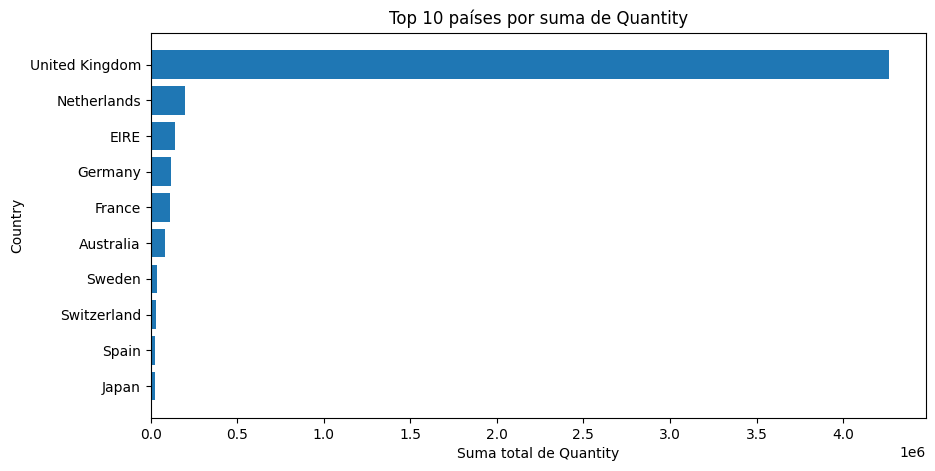

In [40]:
# Exemplo: Crear un gráfico en Pandas/Matplotlib a partir do DataFrame obtido

import matplotlib.pyplot as plt

# Renomeamos a columna agregada para que sexa máis cómoda de usar e visualizar
# Spark adoita chamar a esta columna "sum(Quantity)"
df_plot = df2_pandas.rename(columns={"sum(Quantity)": "sum_quantity"})

# Ordenamos por suma descendente e quedamos cos 10 primeiros países para que o gráfico sexa lexible
df_top10 = df_plot.sort_values("sum_quantity", ascending=False).head(10)

# Creamos un gráfico de barras horizontal (máis lexible con nomes de países)
plt.figure(figsize=(10, 5))
plt.barh(df_top10["Country"], df_top10["sum_quantity"])
plt.xlabel("Suma total de Quantity")
plt.ylabel("Country")
plt.title("Top 10 países por suma de Quantity")
plt.gca().invert_yaxis()
plt.show()
